# Discourse Markers
list: https://github.com/sileod/Discovery/blob/master/data/markers_list.txt
paper: https://arxiv.org/abs/1903.11850

In [3]:
import os
import pandas as pd
import sqlite3
import re
import matplotlib.pyplot as plt
import seaborn as sns


from helpers.occurences import count_occurrences, count_punctuation
from helpers.statistical_tests import run_t_test_on_gender

db_path = "../../giicg.db"
if not os.path.exists(db_path):
    raise FileNotFoundError(f"Database file does not exist: {db_path}")

conn = sqlite3.connect(db_path)
prompts = pd.read_sql("SELECT * FROM main.expanded_prompts", conn)
prompts = prompts.dropna(subset=['conversational'])
prompts = prompts[prompts['conversational'].str.strip() != '']
prompts = prompts.dropna(subset=['conversational'])
prompts

,message_id,conversation_id,role,message_text,conversational,code,other,gender,user_id,language
0,1,1,user,"parsing data from python iterator, how it coul...","parsing data from python iterator, how it coul...",,,Man (cisgender),6,en
1,730,32,user,Write python function to do operations with in...,Write python function to do operations with in...,,report_dt\tsource\tmetric_name\tmetric_num\tme...,Man (cisgender),6,en
2,1133,55,user,Write shortest tutorial on creating RAG on ema...,Write shortest tutorial on creating RAG on ema...,,,Man (cisgender),6,en
3,1135,55,user,what is FAISS,what is FAISS,,,Man (cisgender),6,en
4,1137,55,user,Transform given code to process large .mbox file,Transform given code to process large .mbox file,,Transform given code to process large .mbox file,Man (cisgender),6,en
...,...,...,...,...,...,...,...,...,...,...
756,1646,82,user,"def run_query(query, n_results):\n query_em...",this is my code. I want to: Get nodes and edge...,"def run_query(query, n_results):\n query_em...",,Man (cisgender),92,en
757,1845,37,user,\n nun möchte ich judgement balancing m...,Now I want to bring judgement balancing into t...,,,Woman (cisgender),29,de
758,1847,37,user,\n ich sehe keine veränderung im Plot. Was ...,I do not see any change in the plot.,,,Woman (cisgender),29,de
759,1849,2,user,\n I am working on the problem of reconstru...,\n I am working on the problem of reconstru...,,Classic CV - Drone navigation\nIf you ever tho...,Man (cisgender),8,en


## Filter discourse markers
remove all markers from the list that are not present in the corpus


In [10]:
import numpy as np

full_text = ' '.join(prompts['conversational'].tolist()).lower()

# Load discourse markers, clean up, and lowercase for matching
with open("markers_list.txt", encoding="utf-8") as f:
    marker_list = [m.strip().lower().rstrip(",") for m in f if m.strip()]


present_markers = []
for marker in marker_list:
    # Create a regex to match marker as full words/phrases (case-insensitive, ignore punctuation)
    pattern = r'\b{}\b'.format(re.escape(marker))
    if re.search(pattern, full_text):
        present_markers.append(marker)

print(f"Markers present in dataset: {present_markers}")

to_remove = ['locally', ]
to_add = ['great', 'good', 'cool', 'okay', 'ok', ]

with open("filtered_markers_list.txt", "w", encoding="utf-8") as f:
    for marker in present_markers:
        f.write(f"{marker}\n")

# Structuring/Sequencing markers (organize information, signal sequence)
structuring_markers = [
    "first", "second", "third", "lastly", "finally", "next", "then", "in the end", "overall", "altogether", "soon", "later", "previously", "now", "currently", "again", "further", "once", "separately"
]

# Contrast/Connection markers (signal contrast, addition, cause/effect, alternatives)
connection_markers = [
    "and", "but", "however", "yet", "although", "though", "instead", "or", "otherwise", "also", "besides", "additionally", "moreover", "plus", "thus",
    "therefore", "so", "accordingly", "rather", "still", "for example", "already", "recently", "sometimes", "suddenly", "together"
]

# Commentary/Interaction markers (speaker attitude, stance, engagement)
interaction_markers = [
    "well", "actually", "basically", "maybe", "only", "really", "sadly", "unfortunately", "especially", "normally", "usually", "here", 'great', 'good', 'cool', 'okay', 'ok'
]

included = structuring_markers + connection_markers + interaction_markers
np.setdiff1d(present_markers,included)



Markers present in dataset: ['accordingly', 'actually', 'additionally', 'again', 'already', 'also', 'although', 'altogether', 'and', 'basically', 'besides', 'but', 'currently', 'especially', 'finally', 'first', 'for example', 'further', 'here', 'however', 'in the end', 'instead', 'lastly', 'later', 'locally', 'maybe', 'next', 'normally', 'now', 'once', 'only', 'or', 'overall', 'plus', 'previously', 'rather', 'really', 'recently', 'sadly', 'second', 'separately', 'so', 'sometimes', 'soon', 'still', 'suddenly', 'then', 'therefore', 'third', 'this', 'though', 'together', 'unfortunately', 'usually', 'well', 'yet']


array(['locally', 'this'], dtype='<U13')

## Combine prompts

In [16]:
user_prompts = (
    prompts.groupby(['user_id', 'gender'])['conversational']
    .apply(' '.join)
    .reset_index()
)

## Count Markers

In [17]:
def count_markers(text, markers):
    total = 0
    for marker in markers:
        total += count_occurrences(text, marker, True)
    return total/len(text.split())

marker_types = ['structuring', 'connection', 'interaction']
marker_lists = [structuring_markers, connection_markers, interaction_markers]

for marker_type, marker_list in zip(marker_types, marker_lists):
    user_prompts[marker_type] = user_prompts['conversational'].apply(lambda x: count_markers(x, marker_list))

user_prompts


,user_id,gender,conversational,structuring,connection,interaction
0,6,Man (cisgender),"parsing data from python iterator, how it coul...",0.005102,0.005102,0.000000
1,8,Man (cisgender),\n I am working on the problem of reconstru...,0.000000,0.000000,0.000000
2,11,Woman (cisgender),Can you adapt the following code so that inste...,0.000000,0.061856,0.000000
3,15,Man (cisgender),SET_ALL_TABLES action is currently not fetchin...,0.027778,0.000000,0.027778
4,16,Woman (cisgender),I want to use Dummy Hot encoding to replace th...,0.005515,0.045956,0.009191
5,25,Man (cisgender),what is the best way to encode and compress a ...,0.009259,0.046296,0.009259
6,28,Woman (cisgender),I have a pandas dataframe like this:\n\nI want...,0.012456,0.046263,0.010676
7,29,Woman (cisgender),Now I want to bring judgement balancing into t...,0.016129,0.064516,0.000000
8,30,Non-binary,"as a NLP and LLM researcher, I am recently dow...",0.010870,0.086957,0.010870
9,31,Man (cisgender),How can I make use of an ObservableHQDatabaseC...,0.000000,0.021739,0.000000


## Group by gender

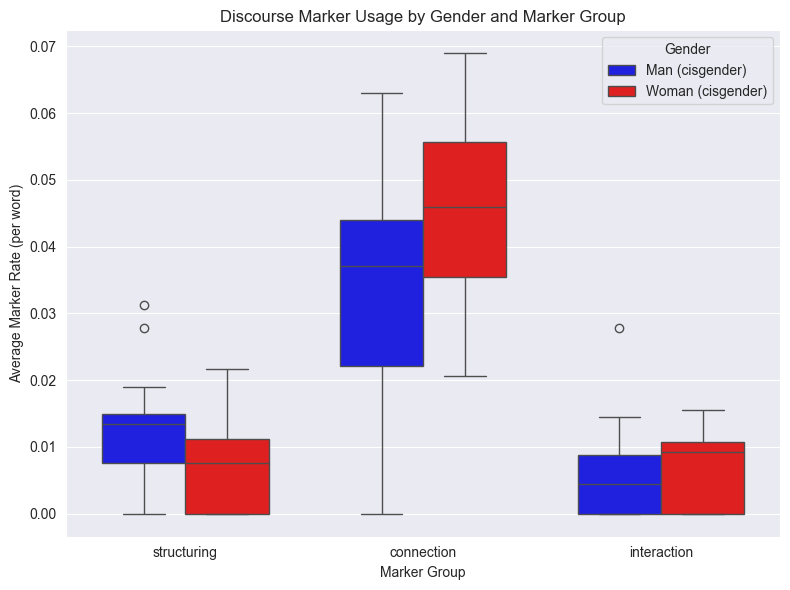

structuring:
  T-statistic: 1.7371, p-value: 0.0943
  Female: n=13, variance=0.0000
  Male:   n=15, variance=0.0001
connection:
  T-statistic: -2.2949, p-value: 0.0302
  Female: n=13, variance=0.0002
  Male:   n=15, variance=0.0003
interaction:
  T-statistic: -0.0660, p-value: 0.9479
  Female: n=13, variance=0.0000
  Male:   n=15, variance=0.0001


In [19]:
filtered = user_prompts[user_prompts['gender'].isin(['Woman (cisgender)', 'Man (cisgender)'])].reset_index(drop=True)

# "Melt" the DataFrame for seaborn
melted = filtered.melt(
    id_vars=['user_id', 'gender'],
    value_vars=['structuring', 'connection', 'interaction'],
    var_name='Marker Group',
    value_name='Normalized Rate'
)

plt.figure(figsize=(8,6))
sns.boxplot(
    data=melted,
    x='Marker Group',
    y='Normalized Rate',
    hue='gender',
    palette={'Woman (cisgender)': 'red', 'Man (cisgender)': 'blue'},
    width=0.7
)

plt.title('Discourse Marker Usage by Gender and Marker Group')
plt.ylabel('Average Marker Rate (per word)')
plt.xlabel('Marker Group')
plt.legend(title='Gender')
plt.tight_layout()
plt.show()

run_t_test_on_gender(filtered, "structuring")
run_t_test_on_gender(filtered, "connection")
run_t_test_on_gender(filtered, "interaction")

## Count individual markers

In [22]:
for marker in connection_markers:
    user_prompts[marker] = user_prompts['conversational'].apply(lambda x: count_occurrences(x, marker, True)/len(x.split()))
    run_t_test_on_gender(user_prompts, marker)

user_prompts


and:
  T-statistic: -2.0228, p-value: 0.0558
  Female: n=13, variance=0.0002
  Male:   n=15, variance=0.0001
but:
  T-statistic: 0.2203, p-value: 0.8274
  Female: n=13, variance=0.0000
  Male:   n=15, variance=0.0000
however:
  T-statistic: 1.0816, p-value: 0.2977
  Female: n=13, variance=0.0000
  Male:   n=15, variance=0.0000
yet:
  T-statistic: 1.0000, p-value: 0.3343
  Female: n=13, variance=0.0000
  Male:   n=15, variance=0.0000
although:
  T-statistic: 1.0000, p-value: 0.3343
  Female: n=13, variance=0.0000
  Male:   n=15, variance=0.0000
though:
  T-statistic: -1.0644, p-value: 0.3081
  Female: n=13, variance=0.0000
  Male:   n=15, variance=0.0000
instead:
  T-statistic: 0.3845, p-value: 0.7037
  Female: n=13, variance=0.0000
  Male:   n=15, variance=0.0000
or:
  T-statistic: -0.6986, p-value: 0.4945
  Female: n=13, variance=0.0001
  Male:   n=15, variance=0.0000
otherwise:
  T-statistic: nan, p-value: nan
  Female: n=13, variance=0.0000
  Male:   n=15, variance=0.0000
also:
  T-

,user_id,gender,conversational,structuring,connection,interaction,and,but,however,yet,...,so,accordingly,rather,still,for example,already,recently,sometimes,suddenly,together
0,6,Man (cisgender),"parsing data from python iterator, how it coul...",0.005102,0.005102,0.000000,0.005102,0.000000,0.000000,0.000000,...,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
1,8,Man (cisgender),\n I am working on the problem of reconstru...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
2,11,Woman (cisgender),Can you adapt the following code so that inste...,0.000000,0.061856,0.000000,0.010309,0.015464,0.000000,0.000000,...,0.015464,0.00000,0.000000,0.005155,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
3,15,Man (cisgender),SET_ALL_TABLES action is currently not fetchin...,0.027778,0.000000,0.027778,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
4,16,Woman (cisgender),I want to use Dummy Hot encoding to replace th...,0.005515,0.045956,0.009191,0.012868,0.005515,0.000000,0.000000,...,0.011029,0.00000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.001838
5,25,Man (cisgender),what is the best way to encode and compress a ...,0.009259,0.046296,0.009259,0.018519,0.000000,0.009259,0.000000,...,0.009259,0.00000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
6,28,Woman (cisgender),I have a pandas dataframe like this:\n\nI want...,0.012456,0.046263,0.010676,0.023132,0.005338,0.000000,0.000000,...,0.012456,0.00000,0.000000,0.000000,0.000000,0.001779,0.00000,0.000000,0.000000,0.000000
7,29,Woman (cisgender),Now I want to bring judgement balancing into t...,0.016129,0.064516,0.000000,0.064516,0.000000,0.000000,0.000000,...,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
8,30,Non-binary,"as a NLP and LLM researcher, I am recently dow...",0.010870,0.086957,0.010870,0.043478,0.000000,0.010870,0.000000,...,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.01087,0.000000,0.000000,0.000000
9,31,Man (cisgender),How can I make use of an ObservableHQDatabaseC...,0.000000,0.021739,0.000000,0.010870,0.000000,0.000000,0.000000,...,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000


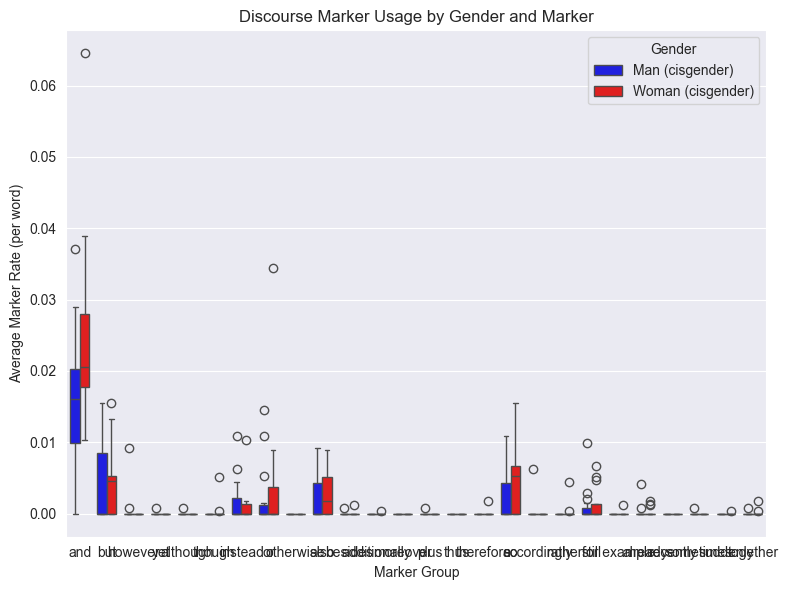

and:
  T-statistic: -2.0228, p-value: 0.0558
  Female: n=13, variance=0.0002
  Male:   n=15, variance=0.0001
but:
  T-statistic: 0.2203, p-value: 0.8274
  Female: n=13, variance=0.0000
  Male:   n=15, variance=0.0000
however:
  T-statistic: 1.0816, p-value: 0.2977
  Female: n=13, variance=0.0000
  Male:   n=15, variance=0.0000
yet:
  T-statistic: 1.0000, p-value: 0.3343
  Female: n=13, variance=0.0000
  Male:   n=15, variance=0.0000
although:
  T-statistic: 1.0000, p-value: 0.3343
  Female: n=13, variance=0.0000
  Male:   n=15, variance=0.0000
though:
  T-statistic: -1.0644, p-value: 0.3081
  Female: n=13, variance=0.0000
  Male:   n=15, variance=0.0000
instead:
  T-statistic: 0.3845, p-value: 0.7037
  Female: n=13, variance=0.0000
  Male:   n=15, variance=0.0000
or:
  T-statistic: -0.6986, p-value: 0.4945
  Female: n=13, variance=0.0001
  Male:   n=15, variance=0.0000
otherwise:
  T-statistic: nan, p-value: nan
  Female: n=13, variance=0.0000
  Male:   n=15, variance=0.0000
also:
  T-

In [25]:
filtered = user_prompts[user_prompts['gender'].isin(['Woman (cisgender)', 'Man (cisgender)'])].reset_index(drop=True)
filtered = filtered.fillna(0)

# "Melt" the DataFrame for seaborn
melted = filtered.melt(
    id_vars=['user_id', 'gender'],
    value_vars=connection_markers,
    var_name='Marker',
    value_name='Normalized Rate'
)

plt.figure(figsize=(8,6))
sns.boxplot(
    data=melted,
    x='Marker',
    y='Normalized Rate',
    hue='gender',
    palette={'Woman (cisgender)': 'red', 'Man (cisgender)': 'blue'},
    width=0.7
)

plt.title('Discourse Marker Usage by Gender and Marker')
plt.ylabel('Average Marker Rate (per word)')
plt.xlabel('Marker Group')
plt.legend(title='Gender')
plt.tight_layout()
plt.show()

for marker in connection_markers:
    run_t_test_on_gender(filtered, marker)